In [1]:
!mkdir results2

하위 디렉터리 또는 파일 results2이(가) 이미 있습니다.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

<h2> 1. Data Preprocessing

<h3> Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

partition = {'train' : trainset, 'val' : valset, 'test' : testset}

Files already downloaded and verified
Files already downloaded and verified


<h3> Pharameters Setting

In [ ]:
# =========== Random Seed initialization =========== #
seed = 111
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_CNN"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# =========== Model Capacirty =========== #
args.act = 'relu'

# =========== Regularization =========== #
args.l2=0.00001

# =========== Optimizer & Training =========== #
args.optim = 'RMSprop'
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# =========== Experiment Variable =========== #
name_var1 = 'lr'
name_var2 = "optim"
list_var1 = [0.0001, 0.00001]
list_var2 = ['RMSprop']

In [4]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

<h2> 2. Model Architecture

In [5]:
class CNN(nn.Module):
    
    def __init__(self, model_mode, in_channels):
        super(CNN, self).__init__()
        
        self.layers = self.make_layers(model_mode, in_channels)
        self.classifier = nn.Sequential(nn.Linear(512, 4096), nn.ReLU(), nn.Linear(4096, 10))
        
    def make_layers(self, model_mode, in_channels):
        layers = nn.ModuleList()
        for x in cfg[model_mode]:
            if x != 'M':
                layers.append(nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, stride=1, padding=1))
                layers.append(nn.ReLU())
                in_channels = x
            else :
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                
        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

<h2> 3. Train & Evaluation Functions

In [6]:
def train(model, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True, num_workers=2)
    model.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return model, train_loss, train_acc

In [7]:
def validate(model, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    model.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.to(args.device)
            labels = labels.to(args.device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [8]:
def test(model, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(args.device)
            labels = labels.to(args.device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        
    return test_acc

In [9]:
def experiment(partition, args):
  
    model = CNN('VGG19', 3)
    model.to(args.device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        st = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(model, partition, criterion, args)
        et = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, et-st))
        
    test_acc = test(model, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    
    return vars(args), result

<h2> Manage Experiment Result

<h3> Save & Load

In [10]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results2/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results2'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

<h3> Visualization Function

In [11]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

<h3> Run Experiment

In [12]:
for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', device='cpu', epoch=10, exp_name='exp1_CNN', l2=1e-05, lr=0.0001, optim='RMSprop', test_batch_size=1024, train_batch_size=256)
Epoch 0, Acc(train/val): 9.79/9.57, Loss(train/val) 2.30/2.30. Took 857.48 sec
Epoch 1, Acc(train/val): 9.92/9.87, Loss(train/val) 2.30/2.30. Took 842.87 sec
Epoch 2, Acc(train/val): 10.06/9.57, Loss(train/val) 2.30/2.30. Took 864.64 sec
Epoch 3, Acc(train/val): 10.11/9.57, Loss(train/val) 2.30/2.30. Took 847.67 sec
Epoch 4, Acc(train/val): 10.11/9.57, Loss(train/val) 2.30/2.30. Took 890.49 sec
Epoch 5, Acc(train/val): 9.77/9.57, Loss(train/val) 2.30/2.30. Took 976.29 sec
Epoch 6, Acc(train/val): 10.11/9.57, Loss(train/val) 2.30/2.30. Took 1127.45 sec
Epoch 7, Acc(train/val): 10.06/9.87, Loss(train/val) 2.30/2.30. Took 1233.04 sec
Epoch 8, Acc(train/val): 9.84/9.57, Loss(train/val) 2.30/2.30. Took 1234.64 sec
Epoch 9, Acc(train/val): 9.83/10.21, Loss(train/val) 2.30/2.30. Took 1282.40 sec
Namespace(act='relu', device='cpu', epoch=10, exp_n

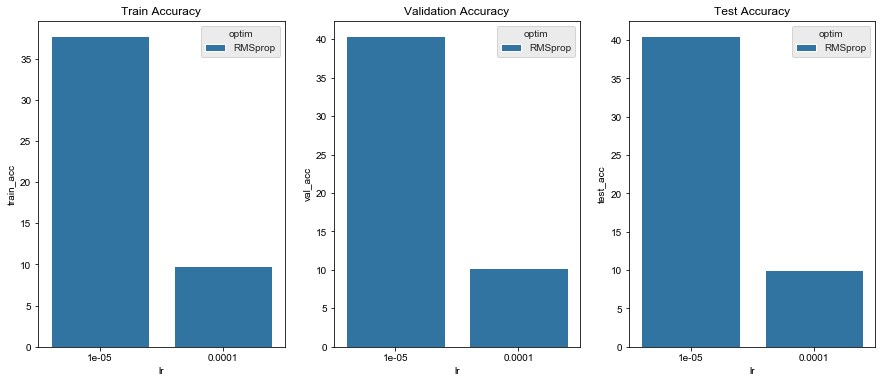

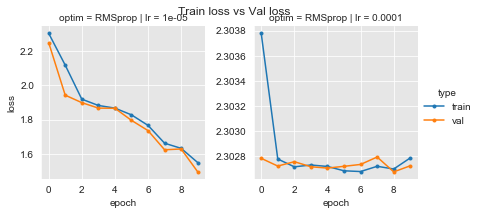

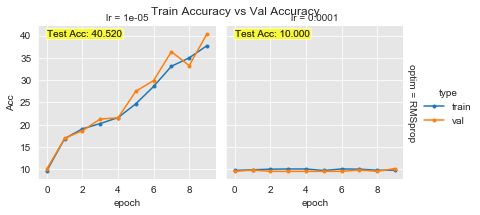

In [13]:
var1 = 'lr'
var2 = 'optim'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False)
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)